## Generate Captions for Trained Model

In [6]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.client import device_lib


In [7]:
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17670828249169628881,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4949437312
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17765656902619720504
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [8]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Download InceptionV3

In [9]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

# new_input = image_model.input#write code here to get the input of the image_model
# hidden_layer = image_model.layers[-1].output#write code here to get the output of the image_model

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)#build the final model using both input & output layer

In [10]:
def initialize_InceptionV3_image_features_extract_model():
    """
    :return: InceptionV3 model instance
    """
    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                    weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output  # shape [batch_size, 8, 8, 2048]

    return tf.keras.Model(new_input, hidden_layer)

In [11]:
embedding_dim = 256 
units = 512
vocab_size = 5001#top 5,000 words +1

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim=256):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [30]:
encoder=Encoder(embedding_dim)

### Attention Model

In [31]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [33]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [34]:
import pickle
def get_caption_tokenizer(caption_tokenizer_path="./checkpoints/tokenizer.pkl"):
    with open(caption_tokenizer_path, "rb") as f:
        return pickle.load(f)

In [52]:
def restore_model(checkpoint_path = "./checkpoints/train", vocab_size=5001):
    tokenizer = get_caption_tokenizer()
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    encoder = Encoder()
    decoder = Decoder(embed_dim=dec_input, units = units, vocab_size = vocab_size)
    optimizer = tf.keras.optimizers.Adam()

    ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer=optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    # if a checkpoint exists, restore the latest checkpoint.
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!')

    return encoder, decoder, tokenizer,initialize_InceptionV3_image_features_extract_model()

In [53]:
encoder, decoder, tokenizer, image_model = restore_model()

Latest checkpoint restored!


In [57]:
from PIL import Image

attention_features_shape = 64

def evaluate(image,max_sequence_len=35,attention_features_shape = 64):
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    
    img_tensor_val = image_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [58]:
vocab_size = len(tokenizer.word_index) + 1

# Preparing validation set data

sample_image = "./data/Images/3767841911_6678052eb6.jpg"

def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    # print(test_image)
    #real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    #plot_attmap(result, attention_plot, test_image)
    #plt.imshow(load_image(test_image)[0])
    
    im = Image.open(openImg)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))
    
#    newsize = (200, 200)
    #openImg = openImg.resize(200,200)
    #return Image.open(openImg).resize(newsize)
    return im

Prediction Caption: a little girl and wet dog getting the her head and her sprinkler

500 353


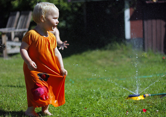

In [59]:
Prediction_Unknown_data(sample_image)